In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from scipy.signal import fftconvolve

import scipy.stats as sps

from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim

import sympy as sp

## Чтение данных

In [2]:
data = pd.read_csv("data.csv")
data

,I,N,t,N-N_f,p,T,mkFermi
0,0.20,1.390,100,-0.610,62.4,3.8,0.0000
1,0.40,1.210,100,-0.790,124.8,15.0,0.0000
2,0.60,1.160,100,-0.840,187.1,33.2,0.0000
3,0.80,2.619,100,0.619,249.5,57.7,199.6506
4,1.00,4.949,100,2.949,311.9,87.7,311.7386
5,1.20,8.787,100,6.787,374.3,122.4,359.8022
6,1.40,12.516,100,10.516,436.7,161.1,355.4049
7,1.60,13.776,100,11.776,499.0,203.2,307.8234
8,1.80,14.526,100,12.526,561.4,248.1,266.8581
9,2.00,15.585,100,13.585,623.8,295.4,236.5798


## Погрешности

$$ \sigma_N = \cfrac{\sqrt{N_\text{полное}}}{t} = \cfrac{\sqrt{N \cdot t}}{t} $$

In [3]:
sigma_I = np.float64('0.005') # A

data["sigma_N"] = np.sqrt(data["N"] * data["t"]) / data["t"]

In [86]:
conv_peak_first = 14
conv_peak_last = 25+1

x = pd.concat([data["I"][:conv_peak_first], data["I"][conv_peak_last:]])
y_noisy = pd.concat([data["N"][:conv_peak_first], data["N"][conv_peak_last:]])
sigma_y = pd.concat([data["sigma_N"][:conv_peak_first], data["sigma_N"][conv_peak_last:]])

x_peak = data["I"][conv_peak_first:conv_peak_last]
y_peak_noisy = data["N"][conv_peak_first:conv_peak_last]
sigma_y_peak = data["sigma_N"][conv_peak_first:conv_peak_last]

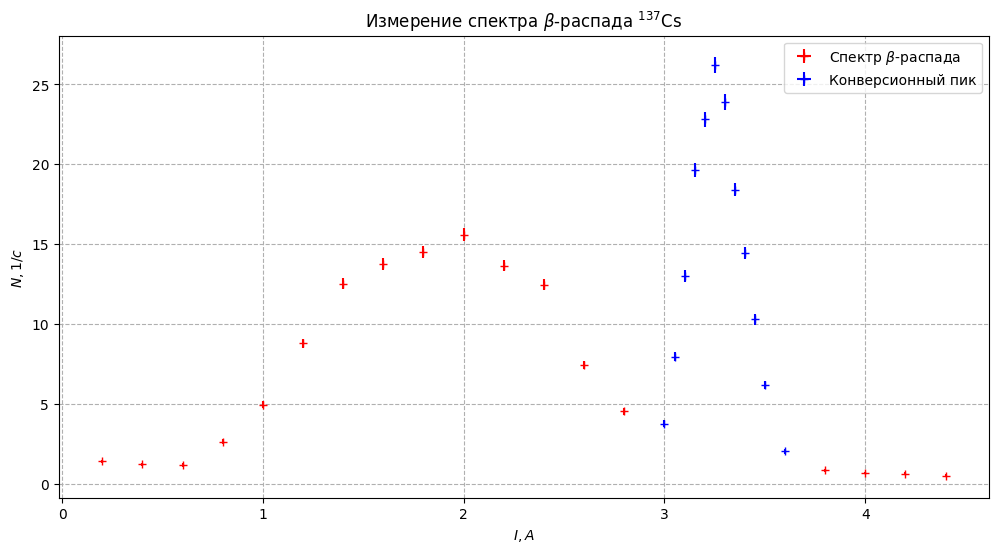

In [5]:
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle="--")
plt.xlabel(r"$I, А$")
plt.ylabel(r"$N, 1 / с$")
plt.title(r"Измерение спектра $\beta$-распада $^{137}$Cs")


plt.errorbar(x, y_noisy, xerr=sigma_I, yerr=sigma_y, fmt="+r", label=r"Спектр $\beta$-распада")
plt.errorbar(x_peak, y_peak_noisy, xerr=sigma_I, yerr=sigma_y_peak, fmt="+b", label="Конверсионный пик")


plt.legend()
plt.savefig("plots/plot_measurements.pdf")
plt.show()

## Учитываем шум

In [6]:
data_background = pd.read_csv("data_background.csv")
data_background.head()

,t,N,dN,I
0,100,1.2797,0.113,0.00
1,100,0.8098,0.090,3.25


In [7]:
# выбрал так, чтобы не было значений ниже 0
noise = 2
sigma_noise = 0.1
print(f"noise = ({noise:.1f} +- {sigma_noise})")

noise = (2.0 +- 0.1)


Погрешность с учетом шума: 

$$ N' = N - N_\text{noise} $$

$$ \sigma_{N'} = \sqrt{\sigma_N^2 + \sigma^2_{\text{noise}}} $$

In [87]:
y = y_noisy - noise
y_peak = y_peak_noisy - noise

sigma_y = np.sqrt(
    np.square(sigma_y) + np.square(sigma_noise)
)
sigma_y_peak = np.sqrt(
    np.square(sigma_y_peak) + np.square(sigma_noise)
)


data["sigma_N"] = np.sqrt(
    np.square(data["sigma_N"]) + np.square(sigma_noise)
)

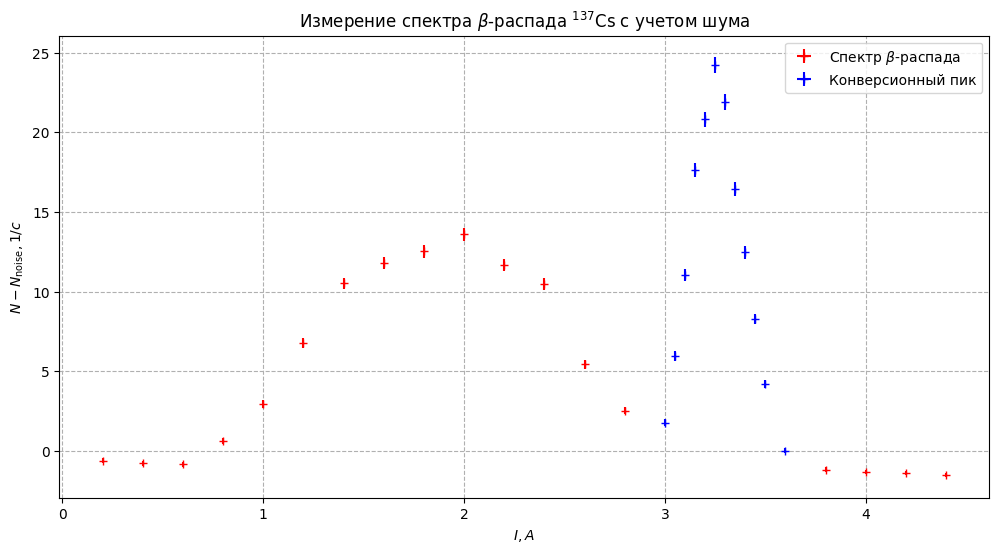

In [9]:
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle="--")
plt.xlabel(r"$I, А$")
plt.ylabel(r"$N - N_\text{noise}, 1 / с$")
plt.title(r"Измерение спектра $\beta$-распада $^{137}$Cs с учетом шума")


plt.errorbar(x, y, xerr=sigma_I, yerr=sigma_y, fmt="+r", label=r"Спектр $\beta$-распада")
plt.errorbar(x_peak, y_peak, xerr=sigma_I, yerr=sigma_y_peak, fmt="+b", label="Конверсионный пик")



plt.legend()
plt.savefig("plots/plot_measurements_noise.pdf")
plt.show()

## Калибруем пик

In [10]:
I_peak = np.float128('3.25')        # А
pc_peak = np.float128('1013.5')     # КэВ
sigma_pc_peak = np.float128('0.05') # КэВ

c = np.float128('299792458')        # м/с
sigma_c = np.float128('0.5')        # м/с

$$ p_e = k I, p_e c = E_{cal} = 1013.5 \ \text{КэВ} \implies k = \cfrac{p_e}{I} = \cfrac{E_{cal}}{c I} $$

Погрешность k:

$$ \sigma_k = \sqrt{ \left( \cfrac{\partial k}{\partial c} \right)^2 \sigma_c^2 + \left( \cfrac{\partial k}{\partial E_{cal}} \right)^2 \sigma_{E_{cal}}^2 + \left( \cfrac{\partial k}{\partial I} \right)^2 \sigma_I^2 } = \sqrt{ \left( - \cfrac{k}{c} \right)^2 \sigma_c^2 + \left( - \cfrac{k}{E_{cal}} \right)^2 \sigma_{E_{cal}}^2 + \left( - \cfrac{k}{I} \right)^2 \sigma_I^2 } = k \sqrt{ \left( \cfrac{\sigma_c}{c} \right)^2 + \left( \cfrac{\sigma_{E_{cal}}}{E_{cal}} \right)^2 + \left( \cfrac{\sigma_I}{I} \right)^2 } $$

In [81]:
k = 1000* np.float128('1.6e-19')*pc_peak / (c * I_peak)
sigma_k = k * np.sqrt(
    np.square(sigma_c / c) + np.square(sigma_pc_peak / pc_peak) + np.square(sigma_I / c)
)
print(f"k = {k*1e27:.0f} +- {sigma_k*1e27:.0f} * 1e-27    м*кг/с*А")
print(f"k = {k* c / np.float64('1.6e-19') /1000:.2f} +- {sigma_k* c / np.float64('1.6e-19') /1000:.2f}    КэВ/с*А")

k = 166433 +- 8 * 1e-27    м*кг/с*А
k = 311.85 +- 0.02    КэВ/с*А


$$ p = kI, \sigma_p = p \sqrt{\varepsilon_k^2 + \varepsilon_I^2} $$

In [88]:
x_pe = x * k * c / np.float64('1.6e-19') /1000
sigma_x_pe = x_pe * np.sqrt(
    np.square(sigma_I / x) + np.square(sigma_k / k)
)

x_pe_peak = x_peak * k * c / np.float64('1.6e-19') /1000
sigma_x_pe_peak = x_pe_peak * np.sqrt(
    np.square(sigma_I / x_peak) + np.square(sigma_k / k)
)

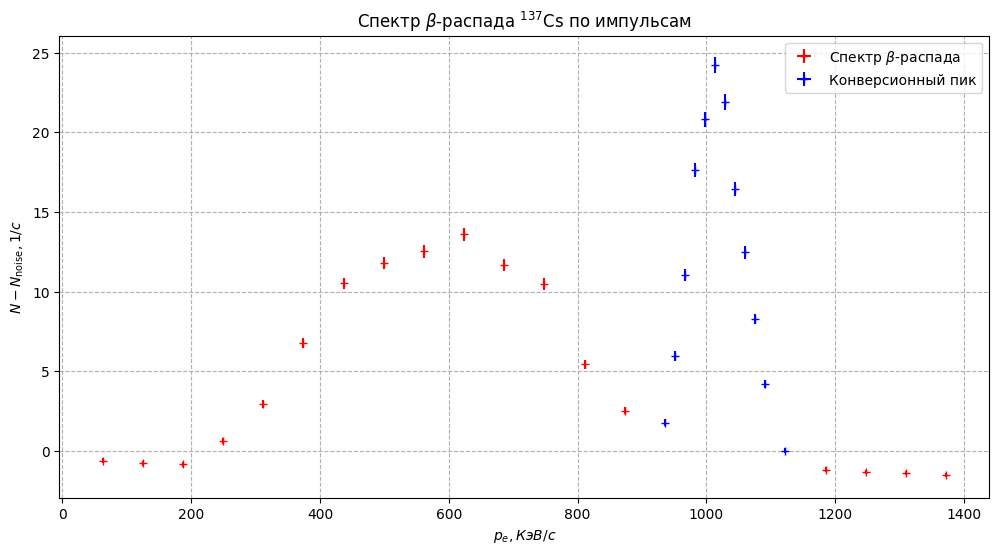

In [13]:
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle="--")
plt.xlabel(r"$p_e, КэВ / с$")
plt.ylabel(r"$N - N_\text{noise}, 1 / с$")
plt.title(r"Спектр $\beta$-распада $^{137}$Cs по импульсам")


plt.errorbar(x_pe, y, xerr=sigma_x_pe, yerr=sigma_y, fmt="+r", label=r"Спектр $\beta$-распада")
plt.errorbar(x_pe_peak, y_peak, xerr=sigma_x_pe_peak, yerr=sigma_y_peak, fmt="+b", label="Конверсионный пик")

plt.legend()
plt.savefig("plots/pe_N.pdf")
plt.show()

## Спектр по энергиям

$$ T = c \sqrt{p_e^2 + m_e^2 c^2} - m_e c^2 = \sqrt{c^2p_e^2 + m_e^2 c^4} - m_e c^2 $$

$$ \sigma_T = \left| \frac{\partial T}{\partial p_e} \right| \sigma_{p_e} = \frac{ {p_e}\sigma_{p_e}}{\sqrt{\left({p_e}\right)^2 + \left(m_e c^2\right)^2}} $$

In [14]:
m_e = np.float128('9.1e-31')        # kg
sigma_m_e = np.float128('0.05e-31') # kg

E_me = m_e * c**2 / np.float64('1.6e-19') /1000 # kev
E_me

np.longdouble('511.16700790656506082')

In [89]:
# Подставляем формулки
x_T = np.sqrt(x_pe**2 + E_me**2) - E_me
sigma_x_T = x_pe * sigma_x_pe / np.sqrt(x_pe**2 + E_me**2)

x_T_peak = np.sqrt(x_pe_peak**2 + E_me**2) - E_me
sigma_x_T_peak = x_pe_peak * sigma_x_pe_peak / np.sqrt(x_pe_peak**2 + E_me**2)

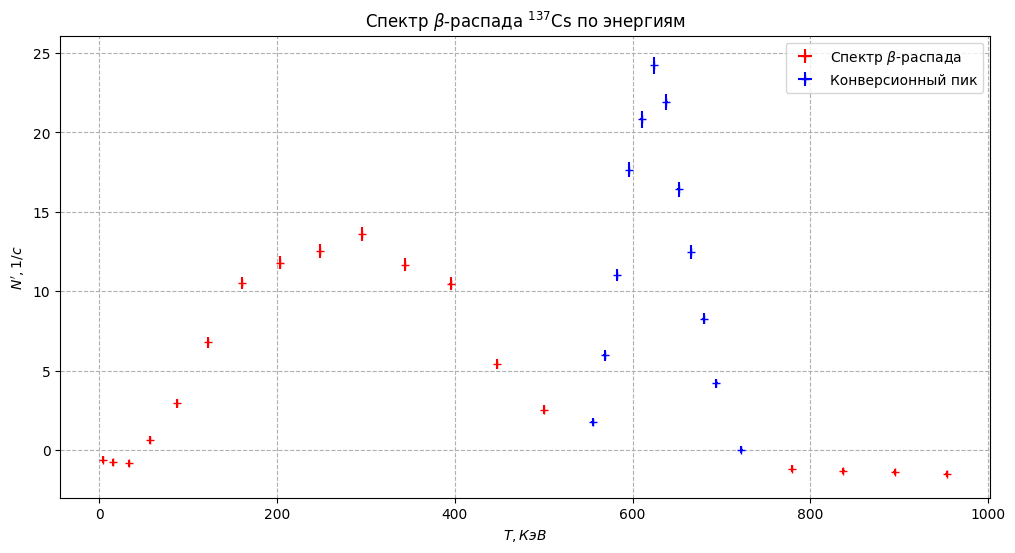

In [177]:
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle="--")
plt.xlabel(r"$T, КэВ$")
plt.ylabel(r"$N', 1 / с$")
plt.title(r"Спектр $\beta$-распада $^{137}$Cs по энергиям")


plt.errorbar(x_T, y, xerr=sigma_x_T, yerr=sigma_y, fmt="+r", label=r"Спектр $\beta$-распада")
plt.errorbar(x_T_peak, y_peak, xerr=sigma_x_T_peak, yerr=sigma_y_peak, fmt="+b", label="Конверсионный пик")


plt.legend()
plt.savefig("plots/T_N.pdf")

plt.show()

### Аппроксимация спектра по Гауссу

In [ ]:
def gaus_func(x, a, mu, sigma, b):
    return a*np.exp(- (x - mu)**2 / (2 * sigma**2)) + b

In [ ]:
def gaus_model(x_model, popt1, popt2):
    y = []
    for x in x_model:
        if x < 500:
            y.append(gaus_func(x, *popt1))
        elif x < min(x_T_peak):
            y.append(
                np.mean([2.5*gaus_func(x, *popt1), gaus_func(x, *popt2)])
            )
        else:
            y.append(gaus_func(x, *popt2))
    return np.array(y)

[ 15.95030886 283.76495428 130.67788392  -1.80462242]
[0.70491498 5.43604885 7.0708796  0.49274431]

[ 24.19239719 625.77371338 -36.61578629  -0.82488095]
[1.07440003 0.96692892 2.08702007 1.09670813]


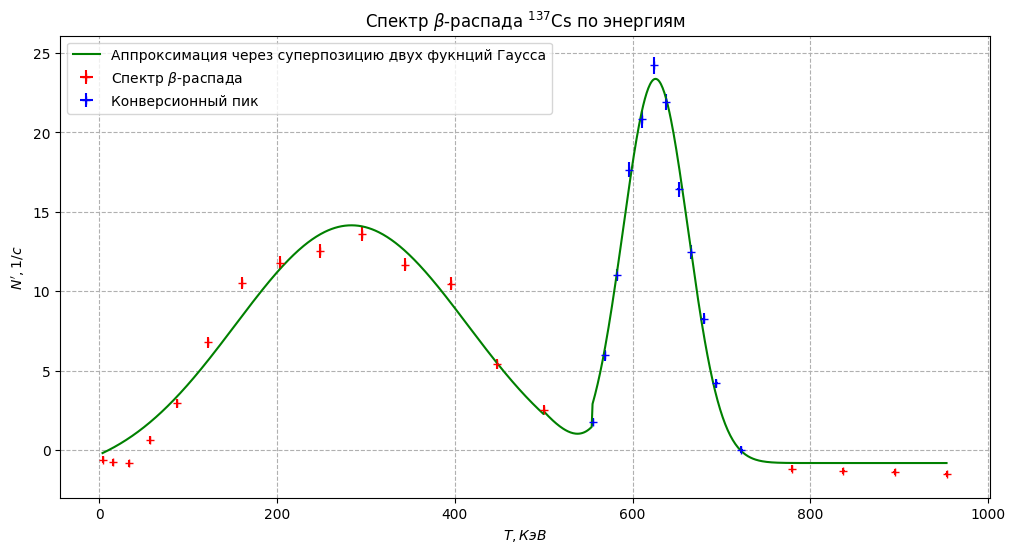

In [178]:
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle="--")
plt.xlabel(r"$T, КэВ$")
plt.ylabel(r"$N', 1 / с$")
plt.title(r"Спектр $\beta$-распада $^{137}$Cs по энергиям")


plt.errorbar(x_T, y, xerr=sigma_x_T, yerr=sigma_y, fmt="+r", label=r"Спектр $\beta$-распада")
plt.errorbar(x_T_peak, y_peak, xerr=sigma_x_T_peak, yerr=sigma_y_peak, fmt="+b", label="Конверсионный пик")


popt_1, pcov_1 = curve_fit(gaus_func, x_T, y, p0=(1, 300, 1, -1), maxfev=10000)
print(popt_1)
print(np.sqrt(np.diag(pcov_1)))
print()

x_reg_model = np.linspace(min(x_T), max(x_T), 1000)

popt_2, pcov_2 = curve_fit(gaus_func, x_T_peak, y_peak, p0=(1, 610, 1, 1))
print(popt_2)
print(np.sqrt(np.diag(pcov_2)))


y_model_final = gaus_model(x_reg_model, popt_1, popt_2)

plt.plot(x_reg_model, y_model_final, color="green", label="Аппроксимация через суперпозицию двух фукнций Гаусса")

plt.legend()
plt.savefig("plots/T_N_gaus_model.pdf")

plt.show()

### аппроксимация с помощью нейронной сети

In [179]:
def show_progress(
    x: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, loss: torch.Tensor
) -> None:
    """Визуализация процесса обучения.

    Параметры: 
    x (torch.Tensor): объекты обучающей выборки;
    y (torch.Tensor): таргеты обучающей выборки;
    y_pred (torch.Tensor): предсказания модели;
    loss (torch.Tensor): текущее значение ошибки модели.
    """

    # Открепим переменную от вычислительного графа перед отрисовкой графика
    y_pred = y_pred.detach()

    # Превратим тензор размерности 0 в число
    loss = loss.item()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, alpha=0.75, label="Обучающая выборка")
    plt.scatter(x, y_pred, color="orange", linewidth=5, label="Предсказания")
    plt.xlabel(r"$T, КэВ$")
    plt.ylabel(r"$N', 1 / с$")
    plt.title("Процесс обучения модели в интерактиве")
    plt.legend()
    plt.show()

    print(f"MSE = {loss:.3f}")


подготовка данных для обучения модели

In [180]:
x_T_data = data["T"]
y_data = data["N-N_f"]

data_nn = pd.DataFrame()

# Будем использовать интерполяцию между точками
T_data = []
N_data = []
interpol_ratio = 4
for i in range(1, len(x_T_data)):
    step = (x_T_data[i] - x_T_data[i-1]) / interpol_ratio
    step_y = (y_data[i] - y_data[i - 1]) / interpol_ratio
    for j in range(interpol_ratio):
        T_data.append(x_T_data[i-1] + step*j)
        N_data.append(y_data[i - 1] + step_y*j)
T_data.append(x_T_data[len(x_T_data) - 1])
N_data.append(y_data[len(y_data) - 1])
data_nn["T"] = T_data

# Отметим как признак пренадлежность к конверсионному пику
is_peak = []
for T in data_nn["T"]:
    if min(x_T_peak) < T < max(x_T_peak):
        is_peak.append(1)
    else:
        is_peak.append(0)
data_nn["is_peak"] = is_peak


data_nn["dist_to_center_dsitribution"] = np.abs(data_nn["T"] - 280) # Расстояние до центра спектра
data_nn["dist_to_peak"] = np.abs(data_nn["T"] - 624) # Расстояние до конверсионного пика


data_nn["T2"] = data_nn["T"] **2 # T^2
data_nn["T3"] = data_nn["T"] **3 # T^3

data_nn["T4"] = data_nn["T"] **4 # T^4

# data_nn["expT"] = np.exp(- np.square(data_nn["dist_to_center_dsitribution"]) / 10000) # Значение N_1
# data_nn["expT_conv"] = np.exp(- np.square(data_nn["dist_to_peak"]) / 10000)           # Значение N_2

data_nn["expT"] = gaus_func(data_nn["T"], *popt_1)      # Значение N_1
data_nn["expT_conv"] = gaus_func(data_nn["T"], *popt_2) # Значение N_2


data_nn["N"] = N_data # target число частиц, тоже проинтерполированное

# Преобразуем в тензоры
X_nn = data_nn.drop(columns=["N"])
y_nn = data_nn["N"]

scaler = StandardScaler()
X_nn_scaled = scaler.fit_transform(X_nn)

X_tensor = torch.FloatTensor(X_nn_scaled)
y_tensor = torch.FloatTensor(y_nn.values).reshape(-1, 1)

Создание модели

In [181]:
model = nn.Sequential(
    nn.Linear(in_features=X_nn.shape[1], out_features=128),
    nn.Sigmoid(),
    nn.Linear(in_features=128, out_features=128),
    nn.Sigmoid(),
    nn.Linear(in_features=128, out_features=64),
    nn.Sigmoid(),
    nn.Linear(in_features=64, out_features=32),
    nn.Sigmoid(),
    nn.Linear(in_features=32, out_features=1),
)

param_groups = [
    {"params": [p for name, p in model.named_parameters() if "weight" in name], "lr": 0.01},
    {"params": [p for name, p in model.named_parameters() if "bias" in name], "lr": 0.05},
]

optim_func = nn.MSELoss()
optimizer = torch.optim.SGD(params=param_groups)

model

Sequential(
  (0): Linear(in_features=9, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=32, out_features=1, bias=True)
)

Обучение

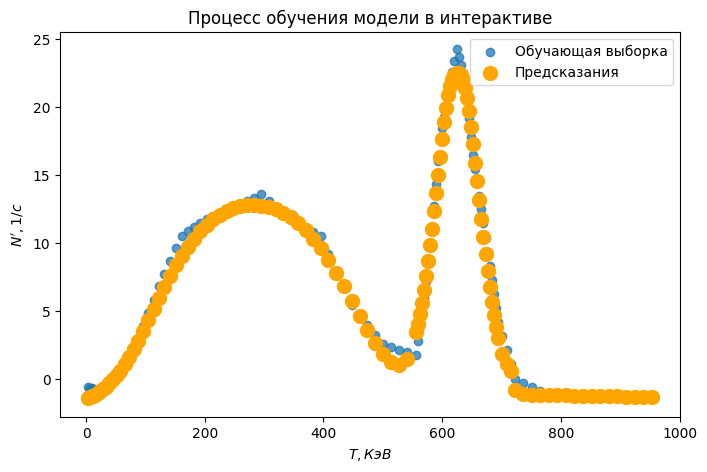

MSE = 0.500
Готово!


In [ ]:
num_iter = 10_000

for i in range(num_iter+1):
    y_pred = model(X_tensor)
    loss = optim_func(y_pred, y_tensor)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()
    
    if (i + 1) % 5 == 0:
        print(f"iteration: {i}")
        show_progress(data_nn["T"], data_nn["N"], y_pred, loss)

        if loss.item() < 0.5:
            print("Готово!")
            break

# torch.save(model.state_dict(), 'model_weights.pth')
# torch.save(model, 'model.pth')

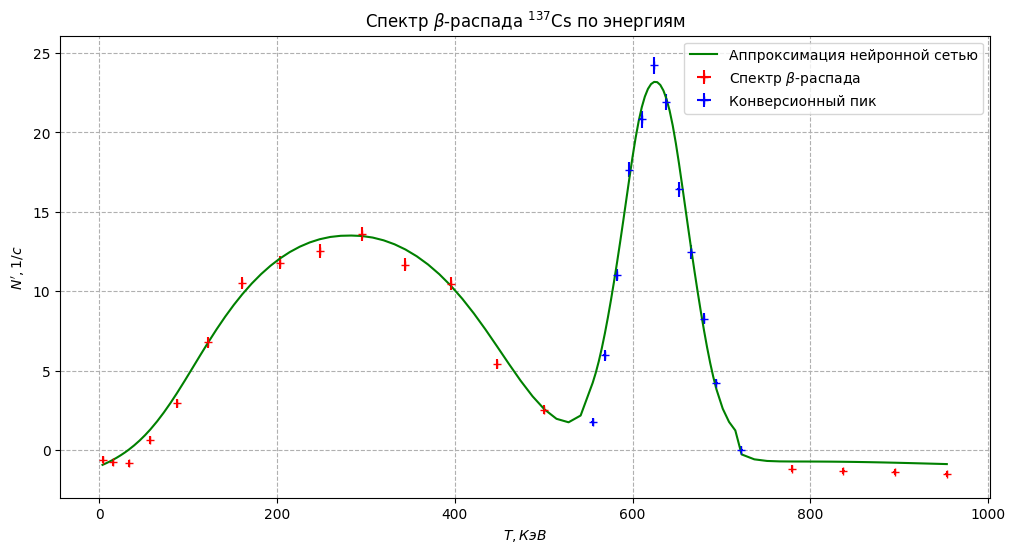

In [188]:
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle="--")
plt.xlabel(r"$T, КэВ$")
plt.ylabel(r"$N', 1 / с$")
plt.title(r"Спектр $\beta$-распада $^{137}$Cs по энергиям")


plt.errorbar(x_T, y, xerr=sigma_x_T, yerr=sigma_y, fmt="+r", label=r"Спектр $\beta$-распада")
plt.errorbar(x_T_peak, y_peak, xerr=sigma_x_T_peak, yerr=sigma_y_peak, fmt="+b", label="Конверсионный пик")

model = torch.load("model.pth", weights_only=False)
model.eval()

with torch.no_grad():
    y_model = model(X_tensor).numpy()
plt.plot(data_nn["T"], y_model, color="green", label="Аппроксимация нейронной сетью")


plt.legend()
plt.savefig("plots/T_N_nn.pdf")

plt.show()

## График Ферми-Кюри

$$ x_\text{fermi} = T, \ \ \ y_\text{fermi} = \cfrac{\sqrt{N(p_e)}}{p_e^{3/2}} \cdot 10^6 $$

Погрешности:

$$ \sigma_{x_\text{fermi}} = \sigma_T, \ \ \ \sigma_{y_\text{fermi}} = \sqrt{ \left( \cfrac{\partial y_\text{fermi}}{\partial N} \right)^2 \sigma_N^2 + \left( \cfrac{\partial y_\text{fermi}}{\partial p_e} \right)^2 \sigma_{p_e}^2 } = \sqrt{ \left( \cfrac{1}{2N}  y_\text{fermi} \right)^2 \sigma_N^2 + \left( -\cfrac{3}{2} \cfrac{1}{p_e} y_\text{fermi} \right)^2 \sigma_{p_e}^2 } = \frac{1}{2} y_\text{fermi} \sqrt{\left(\cfrac{\sigma_N}{N}\right)^2 + \left(\cfrac{3\sigma_{p_e}}{p_E}\right)^2} $$

In [90]:
x_fermi = x_T
y_fermi = 1e6 * np.sqrt(y) / np.pow(x_pe, 3/2)
sigma_x_fermi = sigma_x_T
sigma_y_fermi = 0.5 * y_fermi * np.sqrt(
    np.square(sigma_y / y) + np.square(3 * sigma_x_pe / x_pe)
)

x_fermi_peak = x_T_peak
y_fermi_peak = 1e6 * np.sqrt(y_peak) / np.pow(x_pe_peak, 3/2)
sigma_x_fermi_peak = sigma_x_T_peak
sigma_y_fermi_peak = 0.5 * y_fermi_peak * np.sqrt(
    np.square(sigma_y_peak / y_peak) + np.square(3 * sigma_x_pe_peak / x_pe_peak)
)

mask = y_fermi.notna()
mask_peak = y_fermi_peak.notna()

x_fermi, y_fermi = x_fermi[mask], y_fermi[mask]
sigma_x_fermi, sigma_y_fermi = sigma_x_fermi[mask], sigma_y_fermi[mask]

x_fermi_peak, y_fermi_peak = x_fermi_peak[mask_peak], y_fermi_peak[mask_peak]
sigma_x_fermi_peak, sigma_y_fermi_peak = sigma_x_fermi_peak[mask_peak], sigma_y_fermi_peak[mask_peak]

/home/lev/Documents/gitrepos/Lab_MIPT/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [73]:
def straight_func(x, k, b):
    return k * x + b

a = -0.79 +- 0.03
b = 466 +- 9
E_e = 592 +- 22


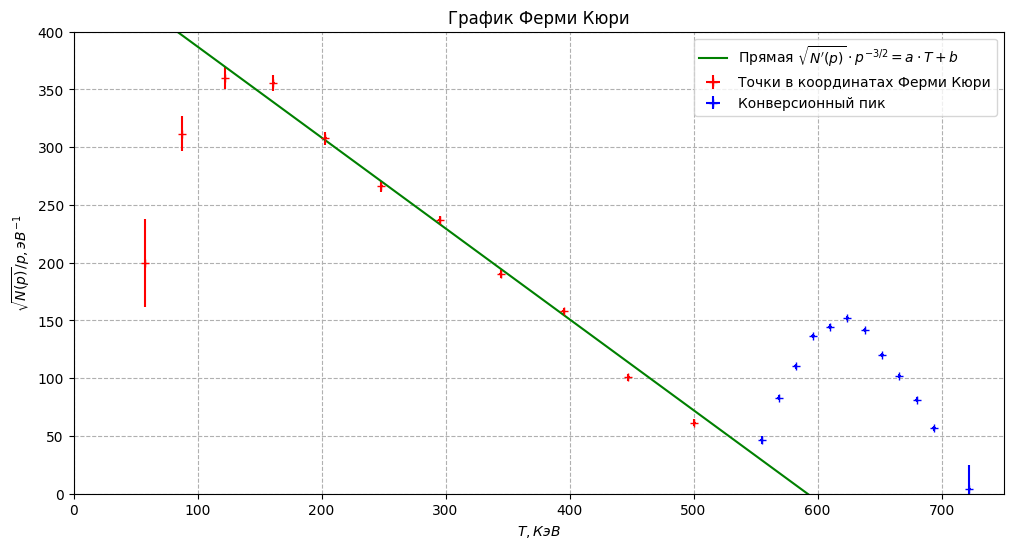

In [138]:
plt.figure(figsize=(12, 6))

plt.grid(True, linestyle="--")
plt.xlabel(r"$T, КэВ$")
plt.ylabel(r"$\sqrt{N(p)} / p, эВ^{-1}$")
plt.title(r"График Ферми Кюри")
plt.xlim((0, 750))
plt.ylim((0, 400))


plt.errorbar(x_fermi, y_fermi, xerr=sigma_x_fermi, yerr=sigma_y_fermi, fmt="+r", label="Точки в координатах Ферми Кюри")
plt.errorbar(x_fermi_peak, y_fermi_peak, xerr=sigma_x_fermi_peak, yerr=sigma_y_fermi_peak, fmt="+b", label="Конверсионный пик")

x_fermi_data = np.concat([x_fermi[2:], [x_fermi_peak.iloc[0]]])
y_fermi_data = np.concat([y_fermi[2:], [y_fermi_peak.iloc[0]]])

# x_fermi_data = x_fermi[2:]
# y_fermi_data = y_fermi[2:]

popt, pcov = curve_fit(straight_func, x_fermi_data, y_fermi_data)

x_model = np.linspace(0, 1000, 10000)
y_model = straight_func(x_model, *popt)
plt.plot(x_model, y_model, color="green", label=r"Прямая $\sqrt{N'(p)} \cdot p^{-3/2} = a \cdot T + b$")

print(f"a = {popt[0]:.2f} +- {np.sqrt(np.diag(pcov))[0]:.2f}")
print(f"b = {popt[1]:.0f} +- {np.sqrt(np.diag(pcov))[1]:.0f}")
print(f"E_e = {- popt[1] / popt[0]:.0f} +- {
    - popt[1] / popt[0] * np.sqrt(np.square(np.sqrt(np.diag(pcov))[0] / popt[0]) + np.square(np.sqrt(np.diag(pcov))[1] / popt[1]))
:.0f}")

plt.legend()
plt.savefig("plots/plot_fermi.pdf")
plt.show()


## Перевод таблицы в LaTex

In [112]:
data_to_print = data.copy()

data_to_print = data_to_print.drop(columns=["t"])
data_to_print["sigma_p"] = data_to_print["p"] * np.sqrt(
    np.square(sigma_I / data_to_print["I"]) + np.square(sigma_k / k)
)

data_to_print["sigma_T"] = data_to_print["p"] * data_to_print["sigma_p"] / np.sqrt(data_to_print["p"]**2 + E_me**2)

data_to_print["sigma_fermi"] = 0.5 * data_to_print["mkFermi"] * np.sqrt(
    np.square(data_to_print["sigma_N"] / data_to_print["N-N_f"]) + np.square(3 * data_to_print["sigma_p"] / data_to_print["p"])
)

column_order = ["I", "N", "N-N_f", "sigma_N", "p", "sigma_p", "T", "sigma_T", "mkFermi", "sigma_fermi"]

data_to_print = data_to_print[column_order]

print(data_to_print.to_latex(formatters={
    "I": "{:0.2f}".format,
    "N": "{:0.1f}".format,
    "N-N_f": "{:0.1f}".format,
    "sigma_N": "{:0.1f}".format,
    "p": "{:0.0f}".format,
    "sigma_p": "{:0.0f}".format,
    "T": "{:0.1f}".format,
    "sigma_T": "{:0.1f}".format,
    "mkFermi": "{:0.0f}".format,
    "sigma_fermi": "{:0.0f}".format,
}))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & I & N & N-N_f & sigma_N & p & sigma_p & T & sigma_T & mkFermi & sigma_fermi \\
\midrule
0 & 0.20 & 1.4 & -0.6 & 0.2 & 62 & 2 & 3.8 & 0.2 & 0 & 0 \\
1 & 0.40 & 1.2 & -0.8 & 0.2 & 125 & 2 & 15.0 & 0.4 & 0 & 0 \\
2 & 0.60 & 1.2 & -0.8 & 0.2 & 187 & 2 & 33.2 & 0.5 & 0 & 0 \\
3 & 0.80 & 2.6 & 0.6 & 0.2 & 250 & 2 & 57.7 & 0.7 & 200 & 38 \\
4 & 1.00 & 4.9 & 2.9 & 0.3 & 312 & 2 & 87.7 & 0.8 & 312 & 15 \\
5 & 1.20 & 8.8 & 6.8 & 0.3 & 374 & 2 & 122.4 & 0.9 & 360 & 9 \\
6 & 1.40 & 12.5 & 10.5 & 0.4 & 437 & 2 & 161.1 & 1.0 & 355 & 7 \\
7 & 1.60 & 13.8 & 11.8 & 0.4 & 499 & 2 & 203.2 & 1.1 & 308 & 6 \\
8 & 1.80 & 14.5 & 12.5 & 0.4 & 561 & 2 & 248.1 & 1.2 & 267 & 5 \\
9 & 2.00 & 15.6 & 13.6 & 0.4 & 624 & 2 & 295.4 & 1.2 & 237 & 4 \\
10 & 2.20 & 13.7 & 11.7 & 0.4 & 686 & 2 & 344.5 & 1.3 & 190 & 3 \\
11 & 2.40 & 12.5 & 10.5 & 0.4 & 749 & 2 & 395.3 & 1.3 & 158 & 3 \\
12 & 2.60 & 7.4 & 5.4 & 0.3 & 811 & 2 & 447.5 & 1.3 & 101 & 3 \\
13 & 2.80 & 4.5 & 2.5 & 0.3 & 87